# Proyecto final de PLN

**Ariana Irasema Sanchez Alvarez**

**Jorge Xavier Paredes Padilla**

En esta libreta vamos a ver el proceso de procesamiento del lenguaje natural aplicado en la politica, veremos como podemos traajar con una base de conocimientos de Tweets para posteriormente hacer una clasificacion manual de personas (liberales, conservadores, neutrales) esto con la intencion usar dos modelos de clasificadores y por ultimo entrenar un modelo de aprendizaje automatico que nos permita clasificar automaticamente.

In [93]:
import re
import numpy as np
import pandas as pd

# Para graficar bonito
import matplotlib.pyplot as plt
import matplotlib.font_manager
import plotly
import plotly.graph_objs as go
import plotly.express as px
plotly.offline.iplot
plotly.offline.init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ClassificationReport

# Los métodos de aprendizaje a utilizar ya provenientes de sklearn
#------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier         # Arbol decisión
from sklearn.ensemble import RandomForestClassifier     # Bósque aleatorios

import seaborn as sns


# Exportar modelo
import pickle5 as pickle

## 1 - Leemos y cargamos la base madre

In [94]:
basemadre_df = pd.read_csv('../data/tweets_base_madre.csv', encoding ='utf-8')

## 2 - Limpiamos la base madre
### 2.1 Normalizacion

In [95]:
def limpiaTexto(text):
    # Cambia texto a minusculas
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #quita las @menciones
    text = re.sub(r'#', '', text) #quita los # simbolos
    remplaza_por_espacios_re = re.compile('[\n(){}\[\]\|,;\"\“\”\‘\’\'\«\»!¡?¿_]')
    text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+','',text) #quita los hyper textos
    return text

basemadre_df['TweetsMuyLimpios'] = basemadre_df['tidy_text'].apply(limpiaTexto)

### 2.3 Estadistica Descriptiva de la base madre

In [96]:
numero_de_casos_por_clasificacion = pd.DataFrame(basemadre_df['clasification'].value_counts())
numero_de_casos_por_clasificacion.index.name = 'clasification'
numero_de_casos_por_clasificacion.columns = ['quantity']

labels = ['Tweets Liberales',
          'Tweets Conservadores',
          'Tweets Neutrales',
          'Tweets Que no Aplican']

values = [numero_de_casos_por_clasificacion['quantity'][0], 
          numero_de_casos_por_clasificacion['quantity'][1], 
          numero_de_casos_por_clasificacion['quantity'][2],
          numero_de_casos_por_clasificacion['quantity'][3]]

# colores
colors = ['#e6ab02','#7570B3','#666666','#C51927']


fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3,)])
fig.update_traces(marker=dict(colors=colors, line=dict(color='#FFFFFF', width=5)))
fig.update(layout_title_text='Número de tweets por clasificación')
fig.show()
fig.write_html("file.html")

In [97]:
numero_de_casos_por_clasificacion = pd.DataFrame(basemadre_df['clasification'].value_counts())
numero_de_casos_por_clasificacion.index.name = 'clasification'
numero_de_casos_por_clasificacion.columns = ['quantity']

labels = ['Tweets Liberales',
          'Tweets Conservadores']

values = [numero_de_casos_por_clasificacion['quantity'][0], 
          numero_de_casos_por_clasificacion['quantity'][1]]

# colores
colors = ['#e6ab02','#7570B3']


fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3,)])
fig.update_traces(marker=dict(colors=colors, line=dict(color='#FFFFFF', width=5)))
fig.update(layout_title_text='Número de tweets por clasificación')
fig.show()
fig.write_html("file.html")

### 2.2 Tokenización

In [98]:
liberales = basemadre_df[basemadre_df["clasification"]==0]
conservadores  = basemadre_df[basemadre_df["clasification"]==1]
neutral = basemadre_df[basemadre_df["clasification"]==2]
noAplica = basemadre_df[basemadre_df["clasification"]==3]

libCon = pd.concat([liberales,conservadores]).reset_index()

# 3 - Clasificación

## 3.1 - Preparación

In [99]:
classes = ['Liberal','Conservador']
X = libCon['tidy_text']
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)
y = libCon['clasification']

In [100]:
# Separa los datos entre datos de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [101]:
X_train.shape, X_test.shape

((3842, 19040), (961, 19040))

## 3.2 Clasificador Arbol de Desición

### 3.2.1 Implementación

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:213: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



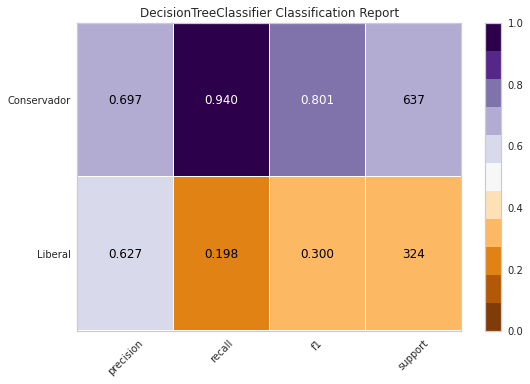

In [102]:
DecisionTree = DecisionTreeClassifier(max_depth=10)
DecisionTree.fit(X_train, y_train)

# Reporte del clasificador
visualizer = ClassificationReport(DecisionTree, classes=classes, support=True, cmap='PuOr')

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()
#print('Exactitud: ', DecisionTree.score(X_test, y_test))
#y_pred = DecisionTree.predict(X_test)
#print(classification_report(y_test, y_pred))

### 3.2.2 - Probando Árboles de decisión

In [103]:
tweet = 'viva la 4t'
dt = tfidf.transform([tweet])
cldt = DecisionTree.predict(dt)
y_preddt = DecisionTree.predict(X_test)
if cldt == 0: 
    print('liberal') 
else: 
    print('conservador')

liberal


### 3.2.3 - Matriz de confusión Árbol de decisión

Text(0.5, 1.0, 'Matriz de confusión Árbol de decisión')

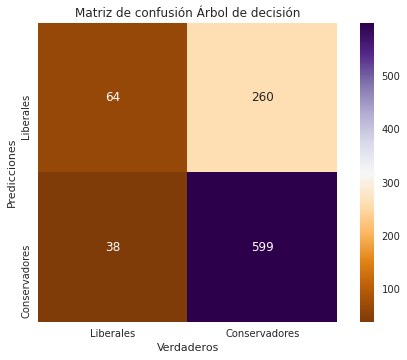

In [104]:
cmAD = confusion_matrix(y_test, y_preddt)
columnasAD = ['Liberales', 'Conservadores']
graficaAD = sns.heatmap(cmAD, annot=True, square=True, fmt='d', cbar=True, cmap='PuOr')

graficaAD.set_xlabel('Verdaderos')
graficaAD.set_ylabel('Predicciones')

tick_marks = np.arange(len(columnasAD)) + 0.5

graficaAD.set_xticks(tick_marks)
graficaAD.set_xticklabels(columnasAD)

graficaAD.set_yticks(tick_marks)
graficaAD.set_yticklabels(columnasAD)

graficaAD.set_title('Matriz de confusión Árbol de decisión')

## 3.3 - Clasificador Random Forest

### 3.3.1 - Implementación

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:213: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



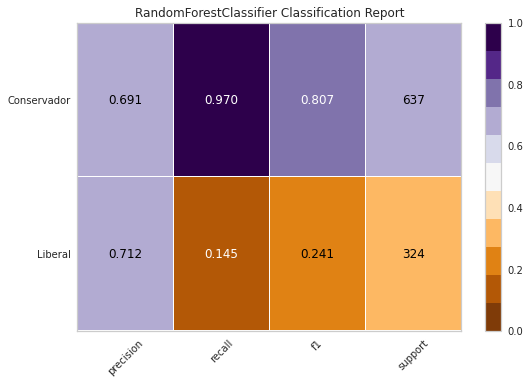

In [105]:
RandomForest = RandomForestClassifier(n_estimators = 100)
RandomForest.fit(X_train, y_train)

# Reporte de clasificador
visualizerRF = ClassificationReport(RandomForest, classes=classes, support=True, cmap='PuOr')

visualizerRF.fit(X_train, y_train)
visualizerRF.score(X_test, y_test)
visualizerRF.show()

### 3.3.2 - Probando Random Forest

In [106]:
prueba = 'amlo es el peor presidente'
rf = tfidf.transform([prueba])
y_predRF = RandomForest.predict(X_test)

clrf = RandomForest.predict(rf)
if clrf == 0: 
    print('liberal') 
else: 
    print('conservador')

conservador


### 3.3.3 - Matriz de confusión RandomForest

Text(0.5, 1.0, 'Matriz de confusión RF')

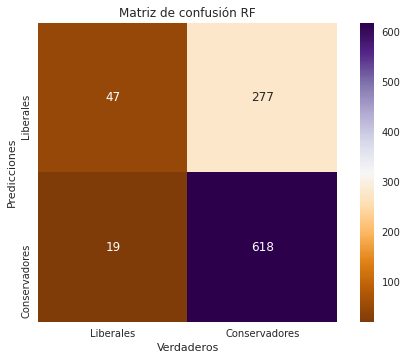

In [107]:
columnas = ['Liberales', 'Conservadores']
cmRF = confusion_matrix(y_test, y_predRF)
graficaRF = sns.heatmap(cmRF, annot=True, square=True, fmt='d', cbar=True, cmap='PuOr')

graficaRF.set_xlabel('Verdaderos')
graficaRF.set_ylabel('Predicciones')

tick_marks = np.arange(len(columnas)) + 0.5

graficaRF.set_xticks(tick_marks)
graficaRF.set_xticklabels(columnas)

graficaRF.set_yticks(tick_marks)
graficaRF.set_yticklabels(columnas)

graficaRF.set_title('Matriz de confusión RF')

## 4 - Generar el modelo

In [108]:
def separacion_de_datos(df,nombreCol,tam):
    Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df[nombreCol],df['clasification'],test_size=tam)
    
    Encoder = LabelEncoder()
    Train_Y = Encoder.fit_transform(Train_Y)
    Test_Y = Encoder.fit_transform(Test_Y)
    
    Tfidf_vect = TfidfVectorizer(max_features=50000)
    Tfidf_vect.fit(df[nombreCol])
    Train_X_Tfidf = Tfidf_vect.transform(Train_X)
    Test_X_Tfidf = Tfidf_vect.transform(Test_X)
    len(Tfidf_vect.vocabulary_)
    return Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y, Tfidf_vect

def entrenarModelo(df):
    Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y, Tfidf_vect = separaData(df,'TweetsMuyLimpios',1)
    myModelo = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
    myModelo.fit(Train_X_Tfidf,Train_Y)
    return myModelo, Tfidf_vect

modeloEntrenado = entrenarModelo(basemadre_df)
modeloEntrenado

(RandomForestClassifier(max_features='sqrt'),
 TfidfVectorizer(max_features=50000))

In [109]:
pickle.dump(modeloEntrenado, open('Modelo.pkl', 'wb'))